# **Homework 3 - Convolutional Neural Network (CNN)**

In [2]:
# 加载谷歌硬盘
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# 添加此选项、不然gdown从Google Drive 中下载会报错
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=38509e6917cc146851f9fa3223b6ecad1395af5c1a3fb669d890454aee685d89
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4agrj9z/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


### 下载数据

In [4]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip


# MEGA
# !sudo apt install megatools
 #!megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.  This may take some time.
!unzip -q food-11.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy
To: /content/food-11.zip
100% 963M/963M [00:05<00:00, 165MB/s]


### 数据集、数据load器、图像转换

In [5]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt

# This is for the progress bar.
# 进度条使用的
from tqdm import tqdm


##### 数据转换

In [6]:
# It is important to do data augmentation in training.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


#### 数据集、数据集加载器

In [7]:
#批量大小、一个合适的批量号、可以获得一个稳定的梯度下降
batch_size = 128

# loader告诉DatasetFolder如何去读取数据
train_set = DatasetFolder('food-11/training/labeled', loader= lambda x: Image.open(x), extensions='jpg', transform=train_tfm)
valid_set = DatasetFolder('food-11/validation', loader= lambda x: Image.open(x), extensions='jpg', transform=test_tfm)
unlabel_set = DatasetFolder('food-11/training/unlabeled',loader=lambda x: Image.open(x), extensions='jpg', transform=train_tfm)
test_set = DatasetFolder('food-11/testing',loader=lambda x: Image.open(x), extensions='jpg', transform=test_tfm)

# 定义dataloader
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)

## 定义你的model
可以选择其他经典model,比如:
model = torchvision.models.resnet18(pretrained=**False**) 

In [8]:
class DIYModel(nn.Module):
    def __init__(self):
        super(DIYModel,self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.full_connect_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        # 把x变成一维的
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        # 一共11个种类、所以最后的输出是11个
        x = self.full_connect_layers(x)
        return x

## 训练

100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


 Trian | epoch: 1, loss: 13.529262561798095, acc: 0.10968749970197678


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


 valid | epoch: 1, loss: 2.4310153325398765, acc: 0.10911458730697632


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 2, loss: 2.270888338088989, acc: 0.1850000023841858


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 2, loss: 2.5481547911961875, acc: 0.1549479216337204


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 3, loss: 2.185904631614685, acc: 0.20906250178813934


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 3, loss: 2.1883667707443237, acc: 0.2408854216337204


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


 Trian | epoch: 4, loss: 2.038768939971924, acc: 0.27937498688697815


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


 valid | epoch: 4, loss: 2.0199557145436606, acc: 0.28854167461395264


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


 Trian | epoch: 5, loss: 1.9780611896514892, acc: 0.3024999797344208


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 5, loss: 2.2930302222569785, acc: 0.22343751788139343


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 6, loss: 1.8930687761306764, acc: 0.3190625011920929


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


 valid | epoch: 6, loss: 4.581796646118164, acc: 0.12031250447034836


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 7, loss: 1.8345362901687623, acc: 0.3396874964237213


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 7, loss: 2.861732323964437, acc: 0.22083334624767303


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 8, loss: 1.7828922700881957, acc: 0.34562498331069946


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


 valid | epoch: 8, loss: 2.19865353902181, acc: 0.27421876788139343


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 Trian | epoch: 9, loss: 1.7094564962387084, acc: 0.3853124976158142


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


 valid | epoch: 9, loss: 2.0646607875823975, acc: 0.3111979365348816


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 10, loss: 1.6743631410598754, acc: 0.40437498688697815


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 10, loss: 2.628223697344462, acc: 0.24296876788139343


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 Trian | epoch: 11, loss: 1.603723292350769, acc: 0.42781248688697815


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


 valid | epoch: 11, loss: 2.016827623049418, acc: 0.3244791626930237


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


 Trian | epoch: 12, loss: 1.6540375280380248, acc: 0.41062498092651367


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


 valid | epoch: 12, loss: 2.597911238670349, acc: 0.27421876788139343


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 13, loss: 1.6149220848083496, acc: 0.42499998211860657


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 13, loss: 1.8817207217216492, acc: 0.34140628576278687


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


 Trian | epoch: 14, loss: 1.5241643857955933, acc: 0.45749998092651367


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


 valid | epoch: 14, loss: 2.0754780570665994, acc: 0.33359378576278687


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 15, loss: 1.5084367179870606, acc: 0.45499998331069946


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


 valid | epoch: 15, loss: 2.098083972930908, acc: 0.3591145873069763


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 16, loss: 1.3836049556732177, acc: 0.5090624690055847


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


 valid | epoch: 16, loss: 1.9181217749913533, acc: 0.3541666865348816


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 17, loss: 1.34518235206604, acc: 0.5331249833106995


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


 valid | epoch: 17, loss: 1.9924143354098003, acc: 0.3255208432674408


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


 Trian | epoch: 18, loss: 1.346839246749878, acc: 0.5303124785423279


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


 valid | epoch: 18, loss: 1.984720766544342, acc: 0.38671875


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 19, loss: 1.2629540491104125, acc: 0.5540624856948853


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


 valid | epoch: 19, loss: 1.836367905139923, acc: 0.3838541507720947


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 20, loss: 1.1794256377220154, acc: 0.5849999785423279


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 20, loss: 1.9287814895311992, acc: 0.43541666865348816


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 Trian | epoch: 21, loss: 1.1640285491943358, acc: 0.5853124856948853


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


 valid | epoch: 21, loss: 1.9300027290980022, acc: 0.4085937440395355


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


 Trian | epoch: 22, loss: 1.1358633399009705, acc: 0.6040624976158142


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


 valid | epoch: 22, loss: 2.037636697292328, acc: 0.38359376788139343


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


 Trian | epoch: 23, loss: 1.0799688839912414, acc: 0.6193749904632568


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 23, loss: 1.9865417679150899, acc: 0.42786461114883423


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 24, loss: 1.0077239513397216, acc: 0.6396874785423279


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 24, loss: 2.317126194636027, acc: 0.3973958492279053


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


 Trian | epoch: 25, loss: 0.9367278623580932, acc: 0.668749988079071


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 25, loss: 2.2508889039357505, acc: 0.40937501192092896


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 26, loss: 0.8568934297561646, acc: 0.7093749642372131


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 26, loss: 2.4798158407211304, acc: 0.3656249940395355


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 27, loss: 0.8645097064971924, acc: 0.7056249976158142


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


 valid | epoch: 27, loss: 2.991404930750529, acc: 0.33151042461395264


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 28, loss: 0.7947139000892639, acc: 0.7262499928474426


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 28, loss: 2.347117861111959, acc: 0.3763020932674408


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 29, loss: 0.6677814602851868, acc: 0.7634375095367432


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 29, loss: 2.673086404800415, acc: 0.42239582538604736


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 30, loss: 0.7018382525444031, acc: 0.7587499618530273


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


 valid | epoch: 30, loss: 2.7536245584487915, acc: 0.40833336114883423


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 31, loss: 0.6578184723854065, acc: 0.7678124904632568


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 31, loss: 2.3966300884882608, acc: 0.40572917461395264


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 32, loss: 0.6561589014530181, acc: 0.776562511920929


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 32, loss: 2.8233015537261963, acc: 0.359375


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 33, loss: 0.43387931704521177, acc: 0.8512499928474426


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


 valid | epoch: 33, loss: 3.113662004470825, acc: 0.37265628576278687


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 34, loss: 0.461871919631958, acc: 0.8374999761581421


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 34, loss: 3.1001482407251992, acc: 0.37291666865348816


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 35, loss: 0.44737296462059023, acc: 0.8487499952316284


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 35, loss: 3.2447719176610312, acc: 0.39479169249534607


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 36, loss: 0.6321709442138672, acc: 0.7837499976158142


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 36, loss: 2.5973782936731973, acc: 0.4127604365348816


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 37, loss: 0.4364670467376709, acc: 0.8493750095367432


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


 valid | epoch: 37, loss: 3.109340031941732, acc: 0.40963542461395264


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 38, loss: 0.472230019569397, acc: 0.8337500095367432


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 38, loss: 3.89873468875885, acc: 0.3528645932674408


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 39, loss: 0.5471857190132141, acc: 0.8234374523162842


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 39, loss: 3.052640755971273, acc: 0.37109375


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 40, loss: 0.38629817247390746, acc: 0.8715624809265137


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 40, loss: 3.212050716082255, acc: 0.3817708492279053


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 41, loss: 0.24683444261550902, acc: 0.9190624952316284


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 41, loss: 3.209840973218282, acc: 0.4088541865348816


100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


 Trian | epoch: 42, loss: 0.39711223483085634, acc: 0.8731249570846558


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


 valid | epoch: 42, loss: 3.4315545558929443, acc: 0.39479169249534607


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


 Trian | epoch: 43, loss: 0.2507751178741455, acc: 0.9118749499320984


100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


 valid | epoch: 43, loss: 3.336583137512207, acc: 0.3895833492279053


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 44, loss: 0.18652670115232467, acc: 0.9428125023841858


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 44, loss: 3.5752116441726685, acc: 0.45104166865348816


100%|██████████| 25/25 [00:23<00:00,  1.04it/s]


 Trian | epoch: 45, loss: 0.21494711488485335, acc: 0.9312499761581421


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 45, loss: 4.121301134427388, acc: 0.3773437440395355


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


 Trian | epoch: 46, loss: 0.2587032034993172, acc: 0.9118749499320984


100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


 valid | epoch: 46, loss: 4.307736714680989, acc: 0.3304687738418579


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 47, loss: 0.294908971786499, acc: 0.9115625023841858


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 47, loss: 3.6151288747787476, acc: 0.41796875


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 48, loss: 0.2381981232762337, acc: 0.9140625


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 48, loss: 3.499327063560486, acc: 0.4085937440395355


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 49, loss: 0.2885570925474167, acc: 0.9015624523162842


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 49, loss: 4.043089032173157, acc: 0.3671875


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 50, loss: 0.181570782661438, acc: 0.9418749809265137


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 50, loss: 3.8235132296880088, acc: 0.38671875


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 51, loss: 0.16023047104477883, acc: 0.9428125023841858


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 51, loss: 3.886864980061849, acc: 0.40000003576278687


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 52, loss: 0.19016546472907067, acc: 0.9346874952316284


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 52, loss: 4.7324808438618975, acc: 0.3919270932674408


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 53, loss: 0.2542531740665436, acc: 0.91468745470047


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 53, loss: 4.239640474319458, acc: 0.3973958492279053


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 54, loss: 0.19114356368780136, acc: 0.9350000023841858


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 54, loss: 4.381202499071757, acc: 0.36640626192092896


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 55, loss: 0.2567351049184799, acc: 0.9228124618530273


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 55, loss: 6.178698221842448, acc: 0.30781251192092896


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 56, loss: 0.2588338115811348, acc: 0.9165624976158142


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 56, loss: 4.0901548862457275, acc: 0.41354167461395264


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 57, loss: 0.19237736091017724, acc: 0.9368749856948853


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


 valid | epoch: 57, loss: 3.9615632692972818, acc: 0.3671875


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 58, loss: 0.24425877287983894, acc: 0.9237499833106995


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 58, loss: 3.521034757296244, acc: 0.4231770932674408


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


 Trian | epoch: 59, loss: 0.08243018805980683, acc: 0.9778124690055847


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


 valid | epoch: 59, loss: 3.90779980023702, acc: 0.4388020932674408


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


 Trian | epoch: 60, loss: 0.13110999569296836, acc: 0.9509374499320984


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


 valid | epoch: 60, loss: 4.185474236806233, acc: 0.39869794249534607


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 61, loss: 0.07527986243367195, acc: 0.9731249809265137


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


 valid | epoch: 61, loss: 4.196059703826904, acc: 0.42734378576278687


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 62, loss: 0.16823337465524674, acc: 0.9453125


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 62, loss: 4.542325337727864, acc: 0.3864583373069763


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 63, loss: 0.18066148042678834, acc: 0.9431249499320984


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


 valid | epoch: 63, loss: 4.409300645192464, acc: 0.3997395932674408


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 64, loss: 0.274283626973629, acc: 0.9149999618530273


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 64, loss: 4.050928552945455, acc: 0.38671875


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 65, loss: 0.13136745616793633, acc: 0.9596874713897705


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 65, loss: 4.10746169090271, acc: 0.42265626788139343


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 66, loss: 0.22557305052876472, acc: 0.9340624809265137


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


 valid | epoch: 66, loss: 4.219280958175659, acc: 0.38984376192092896


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 67, loss: 0.08711103297770023, acc: 0.9728124737739563


100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


 valid | epoch: 67, loss: 4.283367117245992, acc: 0.42395836114883423


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 68, loss: 0.030641157738864423, acc: 0.9893749952316284


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


 valid | epoch: 68, loss: 4.872819264729817, acc: 0.39140626788139343


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 69, loss: 0.03739147884771228, acc: 0.9912499785423279


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


 valid | epoch: 69, loss: 5.009923537572225, acc: 0.375


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 70, loss: 0.02353053105995059, acc: 0.9940624833106995


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


 valid | epoch: 70, loss: 4.749632755915324, acc: 0.43125003576278687


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 71, loss: 0.024201438240706922, acc: 0.9909374713897705


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 71, loss: 4.541322231292725, acc: 0.43359375


100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


 Trian | epoch: 72, loss: 0.08023117501288653, acc: 0.9768750071525574


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


 valid | epoch: 72, loss: 4.604715188344319, acc: 0.3825520873069763


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 73, loss: 0.06859869342297316, acc: 0.97718745470047


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


 valid | epoch: 73, loss: 4.927087386449178, acc: 0.37682291865348816


100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


 Trian | epoch: 74, loss: 0.03199739890173078, acc: 0.9903124570846558


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 74, loss: 4.510002056757609, acc: 0.43515628576278687


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 75, loss: 0.1721151813864708, acc: 0.9456250071525574


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 75, loss: 4.90657393137614, acc: 0.39218753576278687


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 76, loss: 0.13467553950846195, acc: 0.9581249952316284


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


 valid | epoch: 76, loss: 4.926883339881897, acc: 0.38229167461395264


100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


 Trian | epoch: 77, loss: 0.09978098597377538, acc: 0.9765625


100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


 valid | epoch: 77, loss: 5.002858877182007, acc: 0.38828128576278687


100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


 Trian | epoch: 78, loss: 0.1519506811350584, acc: 0.9509374499320984


100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


 valid | epoch: 78, loss: 4.7241387367248535, acc: 0.3671875


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 79, loss: 0.14014359563589096, acc: 0.9549999833106995


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


 valid | epoch: 79, loss: 4.914891640345256, acc: 0.3739583492279053


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


 Trian | epoch: 80, loss: 0.0562777236290276, acc: 0.98499995470047


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


 valid | epoch: 80, loss: 4.214255332946777, acc: 0.43125003576278687


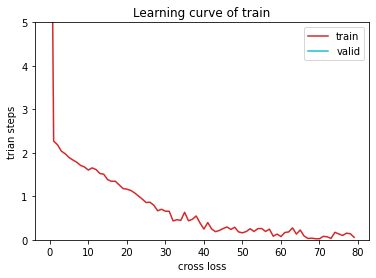

In [9]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# 初始化model、并把model放入device中
model = DIYModel().to(device)
model.device = device

# 损失函数、交叉熵、用于分类loss
criterion = nn.CrossEntropyLoss()

# 优化器、计算梯度下降
optim = torch.optim.Adam(model.parameters(),lr=0.005)

# The number of training epochs.
n_epochs = 80

# semi-supervised learning 中想做一些其他事情、则需要就可以
do_semi = False
loss_record = []
valid_record = []
for epoch in range(n_epochs):
    if do_semi:
        # 做一些训练之外的事情
        pseudo_set = get_pseudo_labels(unlabeled_set, model)
        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------

    # 设置为训练模式
    model.train()
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        #   前一步的梯度被存储、应该先清除
        optim.zero_grad()
        # 计算梯度
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optim.step()
        #acc为什么还这样计算不了解,
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    
    tr_loss = sum(train_loss) / len(train_loss)
    tr_acc  = sum(train_accs) / len(train_accs)
    loss_record.append(tr_loss)
    print(" Trian | epoch: {}, loss: {}, acc: {}".format(epoch+1,tr_loss,tr_acc))

    # ---------- Validation ----------
    valid_loss = []
    valid_acc = []
    # 设定模型为评估类型
    model.eval()
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
         #计算loss
        loss = criterion(logits, labels.to(device))

        #计算acc
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_acc.append(acc)
    val_loss = sum(valid_loss) / len(valid_loss)
    val_acc = sum(valid_acc) / len(valid_acc)
    print(" valid | epoch: {}, loss: {}, acc: {}".format(epoch+1,val_loss,val_acc))
    epoch +=1
    # 遇到10的倍数或者最后一次保存模型
    if epoch % 10 ==0 | epoch == n_epochs:
        torch.save(model.state_dict,'./model_hw3')
        print(" save model | epoch: {}, loss: {}, acc: {}".format(epoch,tr_loss,tr_acc))

plt.figure(figsize=(6,4))
plt.plot(range(len(loss_record)), loss_record, c='tab:red', label='train')
plt.plot(range(len(valid_record)), valid_record, c='tab:cyan', label='valid')
plt.ylim(0.0, 5)
plt.ylabel('trian steps')
plt.xlabel('cross loss')
plt.title('Learning curve of train')
plt.legend()
plt.show()